In [1]:
from models_code.utilities import create_model
from models_code.utilities import dump_results

from models_code.experiments import correlation_test_error_uncertainty
from models_code.experiments import load_lfw
from models_code.experiments import not_mnist_predictions
from models_code.experiments import non_distribution
from models_code.experiments import test_eval
from models_code.experiments import softmax2d

from models_code.mnist import perform_training

from models_code.cifar import load_data
from models_code.cifar import load_svhn
from models_code.cifar import ISCifar
from models_code.cifar import DeVriesCifar

from models_code.utilities import load_model

from utilities.metric import entropy

import torch

import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [2]:
def set_same_seed():
    torch.manual_seed(9)
    torch.cuda.manual_seed(9)

In [3]:
batch_size = 64
log_interval = 100
epochs = 100

DeVries

In [4]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from torch.nn.functional import dropout
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

def encode_onehot(labels, n_classes):
    onehot = torch.FloatTensor(labels.size()[0], n_classes)
    labels = labels.data
    if labels.is_cuda:
        onehot = onehot.cuda()
    onehot.zero_()
    onehot.scatter_(1, labels.view(-1, 1), 1)
    return onehot

In [8]:
def train_devries(
        lmbda,
        epoch,
        model,
        train_loader,
        optimizer,
        loss_function,
        log_interval,
        num_batches,
        channels=1
):
    model.train()
    train_loss = 0
    accuracy = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        data = torch.autograd.Variable(data)
        data = data.cuda()
        optimizer.zero_grad()
        y_, confidence =  model(data.view(-1, channels, 32, 32))
        pred_original = torch.softmax(y_, dim=-1)
        confidence = torch.sigmoid(confidence)
        labels_onehot = torch.autograd.Variable(encode_onehot(y, 10)).cuda()

        eps = 1e-12
        pred_original = torch.clamp(pred_original, 0. + eps, 1. - eps)
        confidence = torch.clamp(confidence, 0. + eps, 1. - eps)

        b = torch.autograd.Variable(torch.bernoulli(torch.Tensor(confidence.size()).uniform_(0, 1))).cuda()
        conf = confidence * b + (1 - b)
        pred_new = pred_original * conf.expand_as(pred_original) + labels_onehot * (1 - conf.expand_as(labels_onehot))
        pred_new = torch.log(pred_new)
        
        xentropy_loss = loss_function(pred_new, torch.autograd.Variable(y).cuda())
        confidence_loss = torch.mean(-torch.log(confidence))
        
        total_loss = xentropy_loss + (lmbda * confidence_loss)

        if 0.5 > confidence_loss.item() :
            lmbda = lmbda / 1.01
        elif 0.5 <= confidence_loss.item() :
            lmbda = lmbda / 0.99

        total_loss.backward()
        train_loss += total_loss.item()
        optimizer.step()

        accuracy += accuracy_score(y, np.argmax(pred_original.cpu().data.numpy(), axis=1))
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       total_loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f} Average accuracy: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset), accuracy / num_batches))
    print(lmbda)
    return lmbda

def test(
        epoch,
        model,
        test_loader,
        optimizer,
        loss_function,
        log_interval,
        channels=1
):
    model.eval()
    test_loss = 0
    y_s = []
    ys = []
    softmax = nn.Softmax()
    for i, (data, y) in enumerate(test_loader):
        data = data.cuda()
        data = Variable(data)
        y_, aft_cauchy = model(data.view(-1, channels, 32, 32))
        y_s.append(softmax(y_).cpu().data.numpy())
        ys.append(y)

        test_loss += loss_function(y_, Variable(y).cuda()).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    print('Test accuracy: {}'.format(accuracy_score(
        np.concatenate(ys),
        np.argmax(np.concatenate(y_s), axis=1)
    )))
    
def perform_training_devries(
    epochs,
    model,
    train_loader,
    test_loader,
    optimizer,
    loss_function,
    log_interval,
    savepath,
    num_batches,
    channels=1
):
    lmbd = 0.1
    
    for epoch in range(1, epochs + 1):
        lmbd = train_devries(
            lmbd,
            epoch,
            model,
            train_loader,
            optimizer,
            loss_function,
            log_interval,
            num_batches,
            channels
        )
        test(
            epoch,
            model,
            test_loader,
            optimizer,
            loss_function,
            log_interval,
            channels
        )
        
        if epoch % 10 == 0:
            torch.save(model.state_dict(), savepath + str(epoch))
        
    torch.save(model.state_dict(), savepath)
    
def test_eval_confidence(
        model,
        test_loader,
        channels=1,
        num_classes=10,
        sentiment=False,
        is_sentiment=False,
        size_factor=1
):
    model.eval()
    all_results = []
    groundtruth = []
    probs = []
    for i, (data, y) in enumerate(test_loader):
        data = data.cuda()
        data = Variable(data)
        if not sentiment and not is_sentiment:
            y_, sec_ = model(data.view(-1, channels, 32*size_factor, 32*size_factor))
        else:
            y_, sec_ = model(data.view(-1, 400))
        all_results.append(
            y_.cpu().data.numpy()[:, :num_classes].argmax(axis=1)
        )
        probs.append(sec_.cpu().data.numpy())
        groundtruth.append(y.cpu().numpy())

    if sentiment:
        return (
            sigmoid(np.concatenate(probs)),
            np.concatenate(groundtruth),
            np.concatenate(probs)
        )

    return (
        np.concatenate(all_results),
        np.concatenate(groundtruth),
        np.concatenate(probs)
    )

def test_eval_confidence_preprocessing(
        model,
        test_loader,
        channels=1,
        num_classes=10,
        sentiment=False,
        is_sentiment=False,
        size_factor=1
):
    model.eval()
    all_results = []
    groundtruth = []
    probs = []
    for i, (data, y) in enumerate(test_loader):
        data = data.cuda()
        data = Variable(data)
        model.zero_grad()
        if not sentiment and not is_sentiment:
            y_, sec_ = model(data.view(-1, channels, 32*size_factor, 32*size_factor))
        else:
            y_, sec_ = model(data.view(-1, 400))
              
        loss = torch.mean(-torch.log(sec_))
        loss.backward()

        data = data - 0.001 * torch.sign(data.grad)
        data = Variable(data.data, requires_grad=True)

        if not sentiment and not is_sentiment:
            y_, sec_ = model(data.view(-1, channels, 32*size_factor, 32*size_factor))
        else:
            y_, sec_ = model(data.view(-1, 400))

        sec_ = torch.sigmoid(sec_)
            
        all_results.append(
            y_.cpu().data.numpy()[:, :num_classes].argmax(axis=1)
        )
        probs.append(sec_.cpu().data.numpy())
        groundtruth.append(y.cpu().numpy())

    if sentiment:
        return (
            sigmoid(np.concatenate(probs)),
            np.concatenate(groundtruth),
            np.concatenate(probs)
        )

    return (
        np.concatenate(all_results),
        np.concatenate(groundtruth),
        np.concatenate(probs)
    )



def not_mnist_predictions_confidence(models, not_mnist_loader, softmaxed=True):
    for model in models:
        model.eval()
    y_truth = []
    probs = []
    images = []
    softmax = torch.nn.Softmax()

    for i, (data, y) in enumerate(not_mnist_loader):
        images.append(data.cpu().numpy())
        y_s = []
        data = data.cuda()
        data = Variable(data)

        for model_ in models:
            output_, q = model_(data[:, 0, :, :].view(-1, 1, 32, 32))
            if softmaxed:
                y_ = softmax(q)
            else:
                y_ = q
            y_s.append(y_.cpu().data.numpy())
        y_truth.append(y.cpu().numpy())
        probs.append(np.stack(y_s))

    return (
        np.concatenate(y_truth),
        np.concatenate(probs, axis=1),
        images
    )


In [9]:
set_same_seed()
train_loader, test_loader = load_data(batch_size)

Files already downloaded and verified


In [7]:
dv, optimizer, nll  = create_model(DeVriesCifar, loss_function=torch.nn.NLLLoss)

perform_training_devries(
    epochs,
    dv,
    train_loader,
    test_loader,
    optimizer,
    nll,
    log_interval,
    './models/cifar_lenet/dv.torch',
    60000 // batch_size + 1,
    channels=3
)

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.021904
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.022605
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.016437
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.017849
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.019220
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.015492
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.021721
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.017231
====> Epoch: 1 Average loss: 0.0170 Average accuracy: 0.4097
0.25577602083933926


/home/msusik/.virtualenvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


====> Test set loss: -0.0030
Test accuracy: 0.3719
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.013122
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.013627
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.011164
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.011552
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.011419
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.010520
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.010954
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.008912
====> Epoch: 2 Average loss: 0.0128 Average accuracy: 0.5288
0.22216005658201302
====> Test set loss: -0.0026
Test accuracy: 0.5388
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.016411
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.013038
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.010563
Train Epoch: 3 [19200/50000 (38%)]	Loss: 0.013351
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.009330
Train Epoch: 3 [32000/50000 (64%)]	Loss: 0.010554
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.008702
Train Epoch: 3 [44800/50000 (90%)]	Loss: 0.012468
====> Epoch: 3 Average loss: 

Train Epoch: 17 [32000/50000 (64%)]	Loss: 0.004876
Train Epoch: 17 [38400/50000 (77%)]	Loss: 0.009203
Train Epoch: 17 [44800/50000 (90%)]	Loss: 0.002401
====> Epoch: 17 Average loss: 0.0052 Average accuracy: 0.7036
0.11103936248329117
====> Test set loss: 0.1979
Test accuracy: 0.7429
Train Epoch: 18 [0/50000 (0%)]	Loss: 0.006062
Train Epoch: 18 [6400/50000 (13%)]	Loss: 0.004914
Train Epoch: 18 [12800/50000 (26%)]	Loss: 0.006032
Train Epoch: 18 [19200/50000 (38%)]	Loss: 0.004223
Train Epoch: 18 [25600/50000 (51%)]	Loss: 0.004540
Train Epoch: 18 [32000/50000 (64%)]	Loss: 0.005131
Train Epoch: 18 [38400/50000 (77%)]	Loss: 0.003664
Train Epoch: 18 [44800/50000 (90%)]	Loss: 0.004078
====> Epoch: 18 Average loss: 0.0050 Average accuracy: 0.7081
0.0964457534805954
====> Test set loss: 0.1502
Test accuracy: 0.7532
Train Epoch: 19 [0/50000 (0%)]	Loss: 0.006005
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.004260
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.003243
Train Epoch: 19 [19200/50000 (38%)]

====> Test set loss: 0.3215
Test accuracy: 0.8208
Train Epoch: 33 [0/50000 (0%)]	Loss: 0.004668
Train Epoch: 33 [6400/50000 (13%)]	Loss: 0.004540
Train Epoch: 33 [12800/50000 (26%)]	Loss: 0.003880
Train Epoch: 33 [19200/50000 (38%)]	Loss: 0.003351
Train Epoch: 33 [25600/50000 (51%)]	Loss: 0.003687
Train Epoch: 33 [32000/50000 (64%)]	Loss: 0.002040
Train Epoch: 33 [38400/50000 (77%)]	Loss: 0.005900
Train Epoch: 33 [44800/50000 (90%)]	Loss: 0.004315
====> Epoch: 33 Average loss: 0.0038 Average accuracy: 0.7411
0.06006784669891784
====> Test set loss: 0.3531
Test accuracy: 0.7859
Train Epoch: 34 [0/50000 (0%)]	Loss: 0.002202
Train Epoch: 34 [6400/50000 (13%)]	Loss: 0.002294
Train Epoch: 34 [12800/50000 (26%)]	Loss: 0.003112
Train Epoch: 34 [19200/50000 (38%)]	Loss: 0.004766
Train Epoch: 34 [25600/50000 (51%)]	Loss: 0.004740
Train Epoch: 34 [32000/50000 (64%)]	Loss: 0.002677
Train Epoch: 34 [38400/50000 (77%)]	Loss: 0.002607
Train Epoch: 34 [44800/50000 (90%)]	Loss: 0.002237
====> Epoch: 3

Train Epoch: 48 [19200/50000 (38%)]	Loss: 0.002762
Train Epoch: 48 [25600/50000 (51%)]	Loss: 0.002873
Train Epoch: 48 [32000/50000 (64%)]	Loss: 0.004571
Train Epoch: 48 [38400/50000 (77%)]	Loss: 0.004804
Train Epoch: 48 [44800/50000 (90%)]	Loss: 0.002335
====> Epoch: 48 Average loss: 0.0029 Average accuracy: 0.7582
0.05693912382432626
====> Test set loss: 0.4360
Test accuracy: 0.8095
Train Epoch: 49 [0/50000 (0%)]	Loss: 0.002558
Train Epoch: 49 [6400/50000 (13%)]	Loss: 0.001611
Train Epoch: 49 [12800/50000 (26%)]	Loss: 0.002120
Train Epoch: 49 [19200/50000 (38%)]	Loss: 0.003891
Train Epoch: 49 [25600/50000 (51%)]	Loss: 0.006066
Train Epoch: 49 [32000/50000 (64%)]	Loss: 0.003809
Train Epoch: 49 [38400/50000 (77%)]	Loss: 0.002596
Train Epoch: 49 [44800/50000 (90%)]	Loss: 0.002547
====> Epoch: 49 Average loss: 0.0030 Average accuracy: 0.7581
0.0514741624725659
====> Test set loss: 0.4616
Test accuracy: 0.8319
Train Epoch: 50 [0/50000 (0%)]	Loss: 0.003107
Train Epoch: 50 [6400/50000 (13%)]

Train Epoch: 63 [44800/50000 (90%)]	Loss: 0.002437
====> Epoch: 63 Average loss: 0.0026 Average accuracy: 0.7679
0.03919228903146854
====> Test set loss: 0.4934
Test accuracy: 0.8372
Train Epoch: 64 [0/50000 (0%)]	Loss: 0.001898
Train Epoch: 64 [6400/50000 (13%)]	Loss: 0.003011
Train Epoch: 64 [12800/50000 (26%)]	Loss: 0.001651
Train Epoch: 64 [19200/50000 (38%)]	Loss: 0.001158
Train Epoch: 64 [25600/50000 (51%)]	Loss: 0.001768
Train Epoch: 64 [32000/50000 (64%)]	Loss: 0.001784
Train Epoch: 64 [38400/50000 (77%)]	Loss: 0.004281
Train Epoch: 64 [44800/50000 (90%)]	Loss: 0.002596
====> Epoch: 64 Average loss: 0.0025 Average accuracy: 0.7695
0.035430651506015494
====> Test set loss: 0.5661
Test accuracy: 0.8133
Train Epoch: 65 [0/50000 (0%)]	Loss: 0.002773
Train Epoch: 65 [6400/50000 (13%)]	Loss: 0.001712
Train Epoch: 65 [12800/50000 (26%)]	Loss: 0.001890
Train Epoch: 65 [19200/50000 (38%)]	Loss: 0.004785
Train Epoch: 65 [25600/50000 (51%)]	Loss: 0.003605
Train Epoch: 65 [32000/50000 (64%

Train Epoch: 79 [0/50000 (0%)]	Loss: 0.002361
Train Epoch: 79 [6400/50000 (13%)]	Loss: 0.003574
Train Epoch: 79 [12800/50000 (26%)]	Loss: 0.001447
Train Epoch: 79 [19200/50000 (38%)]	Loss: 0.001033
Train Epoch: 79 [25600/50000 (51%)]	Loss: 0.002528
Train Epoch: 79 [32000/50000 (64%)]	Loss: 0.003876
Train Epoch: 79 [38400/50000 (77%)]	Loss: 0.002274
Train Epoch: 79 [44800/50000 (90%)]	Loss: 0.000744
====> Epoch: 79 Average loss: 0.0022 Average accuracy: 0.7770
0.03292014014323096
====> Test set loss: 0.6995
Test accuracy: 0.8502
Train Epoch: 80 [0/50000 (0%)]	Loss: 0.000828
Train Epoch: 80 [6400/50000 (13%)]	Loss: 0.002665
Train Epoch: 80 [12800/50000 (26%)]	Loss: 0.001070
Train Epoch: 80 [19200/50000 (38%)]	Loss: 0.002505
Train Epoch: 80 [25600/50000 (51%)]	Loss: 0.002902
Train Epoch: 80 [32000/50000 (64%)]	Loss: 0.001297
Train Epoch: 80 [38400/50000 (77%)]	Loss: 0.001307
Train Epoch: 80 [44800/50000 (90%)]	Loss: 0.000892
====> Epoch: 80 Average loss: 0.0023 Average accuracy: 0.7773
0.

Train Epoch: 94 [25600/50000 (51%)]	Loss: 0.002164
Train Epoch: 94 [32000/50000 (64%)]	Loss: 0.002303
Train Epoch: 94 [38400/50000 (77%)]	Loss: 0.000753
Train Epoch: 94 [44800/50000 (90%)]	Loss: 0.002440
====> Epoch: 94 Average loss: 0.0021 Average accuracy: 0.7808
0.03589497423258804
====> Test set loss: 0.8945
Test accuracy: 0.8257
Train Epoch: 95 [0/50000 (0%)]	Loss: 0.003703
Train Epoch: 95 [6400/50000 (13%)]	Loss: 0.002884
Train Epoch: 95 [12800/50000 (26%)]	Loss: 0.001120
Train Epoch: 95 [19200/50000 (38%)]	Loss: 0.001551
Train Epoch: 95 [25600/50000 (51%)]	Loss: 0.001167
Train Epoch: 95 [32000/50000 (64%)]	Loss: 0.000856
Train Epoch: 95 [38400/50000 (77%)]	Loss: 0.000410
Train Epoch: 95 [44800/50000 (90%)]	Loss: 0.003251
====> Epoch: 95 Average loss: 0.0021 Average accuracy: 0.7814
0.03445646284107629
====> Test set loss: 0.7441
Test accuracy: 0.8297
Train Epoch: 96 [0/50000 (0%)]	Loss: 0.001381
Train Epoch: 96 [6400/50000 (13%)]	Loss: 0.000915
Train Epoch: 96 [12800/50000 (26%)

In [7]:
dv = load_model(DeVriesCifar, './models/cifar_lenet/dv.torch')

In [10]:
test_preds, test_labels, test_probs = test_eval(dv, test_loader, channels=3)
test_preds, test_labels, confidence = test_eval_confidence(dv, test_loader, channels=3)

In [11]:
accuracy_score(test_labels, test_preds)

0.857

In [12]:
log_loss(test_labels, softmax2d(test_probs[:,:10]))

15.95212538322968

### Second experiment

In [13]:
roc, ac, fpr, tpr, pr, re = correlation_test_error_uncertainty(
    lambda x: -x,
    confidence,
    test_labels
)

In [14]:
roc

0.43993238888888897

In [15]:
ac

0.8937619367047802

In [ ]:
# dump_results(fpr, tpr, pr, re, './results/mnist/is.pickle')

### Third experiment

In [16]:
svhn_loader = load_svhn(batch_size)

Using downloaded and verified file: ../data/train_32x32.mat


In [17]:
svhn_preds, svhn_labels, notmnist_confidence = test_eval_confidence(dv, svhn_loader, channels=3)

In [18]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    -confidence,
    -notmnist_confidence,
    83257,
    10000
)

In [19]:
roc

0.8528133093083254

In [20]:
ac

0.948783061005954

In [ ]:
dump_results(fpr, tpr, pr, re, './results/notmnist/is.pickle')

In [48]:
from matplotlib import pyplot as plt

In [49]:

def sigmoid(x):
    return 1/(1+np.exp(-x))

(array([  505., 10362., 50296., 10818.,   360.,   221.,   158.,   139.,
          127.,   271.]),
 array([0.02189137, 0.11970223, 0.2175131 , 0.31532395, 0.4131348 ,
        0.5109457 , 0.60875654, 0.7065674 , 0.8043783 , 0.90218914,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

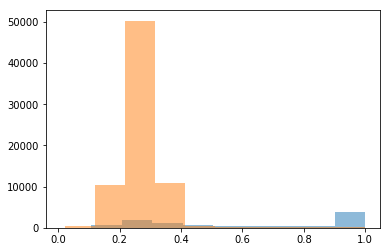

In [50]:
plt.hist(sigmoid(confidence), alpha=0.5)
plt.hist(sigmoid(notmnist_confidence), alpha=0.5)

### LFW-a

In [ ]:
lfw_loader = load_lfw(batch_size)

In [ ]:
lfw_preds, lfw_labels, lfw_probs = test_eval(is_, lfw_loader, channels=3)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_probs,
    softmax2d(test_probs)[:,10].reshape(10000,1),
    softmax2d(lfw_probs)[:,10].reshape(1054,1),
    11054,
    10000
)


In [ ]:
roc

In [ ]:
ac